In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
import re
from copy import deepcopy
flatten = lambda l: [item for sublist in l for item in sublist]

import matplotlib.pyplot as plt
import itertools
import pandas as pd
import pickle

#random.seed(1024)
%matplotlib inline

pd.options.display.max_rows=1000


In [2]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def getBatch_MultiHead(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [109]:
def pad_to_batch_MultiHead(batch):
    x_text, x_ref, y, x_text_actual = zip(*batch)
    max_x_text = max([s.size(1) for s in x_text])
    x_p_text = []
    x_p_text_actual = []
    for i in range(len(batch)):
        if x_text[i].size(1) < max_x_text:
            x_p_text.append(torch.cat([x_text[i], Variable(LongTensor([word2index['<PAD>']] * (max_x_text - x_text[i].size(1)))).view(1, -1)], 1))
        else:
            x_p_text.append(x_text[i])
        x_p_text_actual.append(x_text_actual)
    return torch.cat(x_p_text), torch.cat(x_ref), torch.cat(y).view(-1), x_p_text_actual

In [5]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

## Data Loading and Pre-processing

In [6]:
inspire_data = pd.read_pickle('inspire_data_with_reference_fractions/inspire_data_with_reference_fractions.df')

In [7]:
X = list(inspire_data['text'])
X_core1 = list(inspire_data['core_references_fraction_first_order'])
X_core2 = list(inspire_data['core_references_fraction_second_order'])
X_noncore1 = list(inspire_data['noncore_references_fraction_first_order'])
X_noncore2 = list(inspire_data['noncore_references_fraction_second_order'])
y = list(inspire_data['labels'])

In [8]:
# Get the class weights
rejected_count = y.count(0)
noncore_count = y.count(1)
core_count = y.count(2)

total_count = len(y)

inverse_rejected_fraction = total_count / rejected_count
inverse_noncore_fraction = total_count / noncore_count
inverse_core_fraction = total_count / core_count 

sum_fractions = inverse_rejected_fraction + inverse_noncore_fraction + inverse_core_fraction

# Specify the class weights (for the loss function specified later)
class_weights = torch.cuda.FloatTensor((inverse_rejected_fraction/sum_fractions,
                                        inverse_noncore_fraction/sum_fractions,
                                        inverse_core_fraction/sum_fractions))

In [9]:
class_weights = class_weights / class_weights[1]
print(class_weights)

tensor([1.8834, 1.0000, 1.1152], device='cuda:0')


##### Lowercase all text

In [18]:
# Lowercase the entire text corpora
X = [x.lower() for x in X]

##### Remove punctuation

In [19]:
punc_to_remove = str('!"%&\'()*+,./:;<=>?@[\\]^_`{|}~')
for i, x in enumerate(X):
    X[i] = ' '.join(word.strip(punc_to_remove) for word in x.split())

##### Num Masking

In [20]:
for i, x in enumerate(X):
    X[i] = re.sub('\d+', '<NUM>', x)

##### Replace Latex Equations

In [21]:
for i, _ in enumerate(X):
    f = re.search(r"(.+(?P<name>\$.+\$).+)+", X[i])
    while f is not None:
        X[i] = re.sub(re.escape(f.group('name')), '<FORMULA>', X[i])
        f = re.search(r"(.+(?P<name>\$.+\$).+)+", X[i])

##### Tokenize the text

In [22]:
X = [nltk.word_tokenize(x) for x in X]

##### Lemmatize the text

In [23]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
X = [[wordnet_lemmatizer.lemmatize(word) for word in x] for x in X]

##### Build vocabulary

In [24]:
vocab = list(set(flatten(X)))
print(len(vocab))

282885


In [25]:
print(len(set(y))) # Number of classes

3


In [26]:
word2index={'<PAD>': 0, '<UNK>': 1}

for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}

target2index = {}

for cl in set(y):
    if target2index.get(cl) is None:
        target2index[cl] = len(target2index)

index2target = {v:k for k, v in target2index.items()}

In [30]:
pickle.dump(word2index, open('inspire_data_with_reference_fractions/word2index.pkl', 'wb'))
pickle.dump(target2index, open('inspire_data_with_reference_fractions/target2index.pkl', 'wb'))
pickle.dump(X, open('inspire_data_with_reference_fractions/encoded_text.pkl', 'wb'))

In [10]:
word2index = pickle.load(open('inspire_data_with_reference_fractions/word2index.pkl', 'rb'))
target2index = pickle.load(open('inspire_data_with_reference_fractions/target2index.pkl', 'rb'))
X_text = pickle.load(open('inspire_data_with_reference_fractions/encoded_text.pkl', 'rb'))

In [104]:
X_p_text, X_p_ref, y_p, X_text_actual = [], [], [], []
for pair in zip(X_text, X_core1, X_core2, X_noncore1, X_noncore2, y, inspire_data.text):
    X_p_text.append(prepare_sequence(pair[0], word2index).view(1, -1))
    X_p_ref.append(Variable(FloatTensor([pair[1], pair[2], pair[3], pair[4]])).view(1, -1))
    y_p.append(Variable(LongTensor([target2index[pair[5]]])).view(1, -1))
    X_text_actual.append(pair[6])

    
data_p = list(zip(X_p_text, X_p_ref, y_p, X_text_actual))
random.shuffle(data_p)

train_data = data_p[: int(len(data_p) * 0.8)]
val_data = data_p[int(len(data_p) * 0.8):]

##### Load pre-trained Word Vectors

In [12]:
import gensim

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
len(model.index2word)

In [ ]:
pretrained = []

for key in word2index.keys():
    try:
        pretrained.append(model[word2index[key]])
    except:
        pretrained.append(np.random.randn(300))
        
pretrained_vectors = np.vstack(pretrained)

## Train

In [259]:
EPOCH = 4
BATCH_SIZE = 64
KERNEL_SIZES = [3,4,5,6]
KERNEL_DIM = 200
DROPOUT = 0.2
LR = 0.001

In [260]:
class  CNN_Classifier_MultiHead(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5):
        super(CNN_Classifier_MultiHead,self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])

                # FC Layer for the reference fractions
        self.fc_reference_fraction = nn.Linear(4, 200)
        
        # kernal_size = (K,D) 
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim + 200, output_size)
    
    
    def init_weights(self, pretrained_word_vectors, is_static=False):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding.weight.requires_grad = False


    def forward(self, text_inputs, reference_fraction_inputs, is_training=False):
        text_inputs = self.embedding(text_inputs).unsqueeze(1) # (B,1,T,D)
        text_inputs = [F.relu(conv(text_inputs)).squeeze(3) for conv in self.convs] #[(N,Co,W), ...]*len(Ks)
        text_inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in text_inputs] #[(N,Co), ...]*len(Ks)

        concated = torch.cat(text_inputs, dim=1)
        
        reference_fraction_out = self.fc_reference_fraction(reference_fraction_inputs)
        super_concatenated = torch.cat((concated, reference_fraction_out), dim=1)

        if is_training:
            super_concatenated = self.dropout(super_concatenated) # (N,len(Ks)*Co)
        out = self.fc(super_concatenated)
        return F.log_softmax(out,1)

In [261]:
model = CNN_Classifier_MultiHead(len(word2index), 300, len(target2index), KERNEL_DIM, KERNEL_SIZES, dropout=DROPOUT)
model.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

if USE_CUDA:
    model = model.cuda()
    
loss_function = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam([
#     {'params': model.embedding.parameters()},
#     {'params': model.convs.parameters()},
#     {'params': model.dropout.parameters()}, 
#     {'params': model.fc.parameters()}, 
#     {'params': model.fc_reference_fraction.parameters(), 'lr': 0.0001}
# ], lr=LR)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.2)

In [262]:
print(model)

CNN_Classifier_MultiHead(
  (embedding): Embedding(282887, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (fc_reference_fraction): Linear(in_features=4, out_features=200, bias=True)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=1000, out_features=3, bias=True)
)


In [263]:
def train_model(train_data, model, loss_function, epoch):
    '''
    Trains the model for one epoch
    '''
    
    model.train()
    avg_loss = []
    avg_train_acc = []
    
    for i, batch in enumerate(getBatch_MultiHead(BATCH_SIZE, train_data)):
        text_inputs, reference_fraction_inputs, targets, _ = pad_to_batch_MultiHead(batch)
        
        model.zero_grad()
        preds = model(text_inputs, reference_fraction_inputs, True)
        
        loss = loss_function(preds, targets)
        loss.backward()
        
        optimizer.step()
        
        train_acc = (sum(preds.max(1)[1] == targets).item() / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('TRAIN [Epoch : {}/{}][Batch: {}] Batch Train Loss: {}, Batch Train Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.item(),
                                                                                                train_acc))
    
        avg_loss.append(loss.item())
        avg_train_acc.append(train_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_train_acc = np.mean(avg_train_acc)

    return avg_loss, avg_train_acc

def validate(val_data, model, loss_function, epoch):
    
    model.eval()
    avg_loss = []
    avg_test_acc = []
    
    for i, batch in enumerate(getBatch_MultiHead(BATCH_SIZE, val_data)):
        text_inputs, reference_fraction_inputs, targets, _ = pad_to_batch_MultiHead(batch)
        
        preds = model(text_inputs, reference_fraction_inputs, False)
        
        loss = loss_function(preds, targets)
        
        test_acc = (sum(preds.max(1)[1] == targets).item() / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('VAL [Epoch : {}/{}][Batch: {}] Batch Test Loss: {}, Batch Test Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.item(),
                                                                                                test_acc))
    
        avg_loss.append(loss.item())
        avg_test_acc.append(test_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_test_acc = np.mean(avg_test_acc)

    return avg_loss, avg_test_acc

In [264]:
train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(EPOCH):
    
#     scheduler.step()
    
    print('<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>')
    epoch_train_loss, epoch_train_acc = train_model(train_data, model, loss_function, epoch)
    print('[TRAIN] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_train_loss, epoch_train_acc))
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    
    print('<<<<<<<<<<<<< VALIDATING >>>>>>>>>>>>')
    epoch_val_loss, epoch_val_acc = validate(val_data, model, loss_function, epoch)
    print('[VAL] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_val_loss, epoch_val_acc))    
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>
TRAIN [Epoch : 0/4][Batch: 0] Batch Train Loss: 1.1011625528335571, Batch Train Accuracy: 45.3125
TRAIN [Epoch : 0/4][Batch: 100] Batch Train Loss: 0.43603086471557617, Batch Train Accuracy: 82.8125
TRAIN [Epoch : 0/4][Batch: 200] Batch Train Loss: 0.19253559410572052, Batch Train Accuracy: 92.1875
TRAIN [Epoch : 0/4][Batch: 300] Batch Train Loss: 0.49755874276161194, Batch Train Accuracy: 78.125
TRAIN [Epoch : 0/4][Batch: 400] Batch Train Loss: 0.3719109296798706, Batch Train Accuracy: 87.5
TRAIN [Epoch : 0/4][Batch: 500] Batch Train Loss: 0.25943899154663086, Batch Train Accuracy: 90.625
TRAIN [Epoch : 0/4][Batch: 600] Batch Train Loss: 0.3244304060935974, Batch Train Accuracy: 92.1875
TRAIN [Epoch : 0/4][Batch: 700] Batch Train Loss: 0.3657664954662323, Batch Train Accuracy: 82.8125
TRAIN [Epoch : 0/4][Batch: 800] Batch Train Loss: 0.3814678192138672, Batch Train Accuracy: 84.375
TRAIN [Epoch : 0/4][Batch: 900] Batch Train Loss: 0.40339571237564087,

TRAIN [Epoch : 2/4][Batch: 1800] Batch Train Loss: 0.15937133133411407, Batch Train Accuracy: 93.75
TRAIN [Epoch : 2/4][Batch: 1900] Batch Train Loss: 0.16952379047870636, Batch Train Accuracy: 92.1875
TRAIN [Epoch : 2/4][Batch: 2000] Batch Train Loss: 0.20954157412052155, Batch Train Accuracy: 89.0625
TRAIN [Epoch : 2/4][Batch: 2100] Batch Train Loss: 0.22327017784118652, Batch Train Accuracy: 93.75
TRAIN [Epoch : 2/4][Batch: 2200] Batch Train Loss: 0.20676733553409576, Batch Train Accuracy: 92.1875
TRAIN [Epoch : 2/4][Batch: 2300] Batch Train Loss: 0.15900859236717224, Batch Train Accuracy: 92.1875
[TRAIN] EPOCH: 2, Loss: 0.15859753236227436, Accuracy: 93.59952708512468
<<<<<<<<<<<<< VALIDATING >>>>>>>>>>>>
VAL [Epoch : 2/4][Batch: 0] Batch Test Loss: 0.24055473506450653, Batch Test Accuracy: 95.3125
VAL [Epoch : 2/4][Batch: 100] Batch Test Loss: 0.18915607035160065, Batch Test Accuracy: 90.625
VAL [Epoch : 2/4][Batch: 200] Batch Test Loss: 0.12437644600868225, Batch Test Accuracy: 9

#### Make loss and accuracy plots

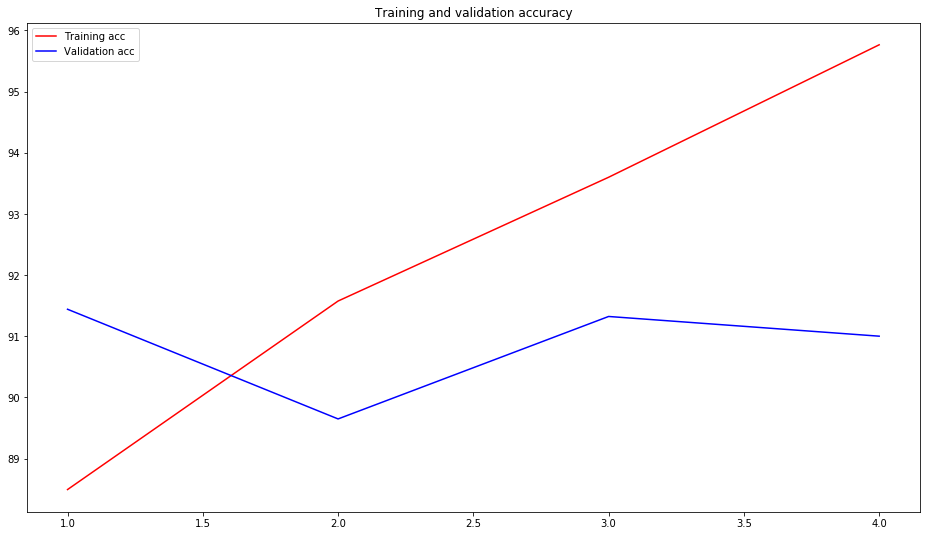

In [265]:
# Accuracy
epochs = range(1, EPOCH + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

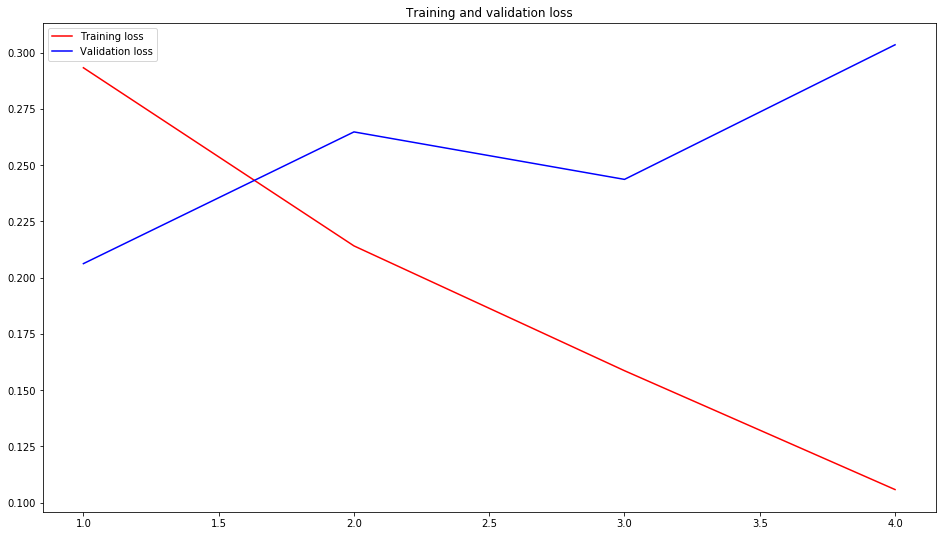

In [266]:
# Loss

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate on validation set

accuracy = 0

for test in val_data:
    pred = model(test[0], test[1], False).max(1)[1]
    pred = pred.data.tolist()[0]
    target = test[1].data.tolist()[0][0]
    if pred == target:
        accuracy += 1

print(accuracy/len(val_data) * 100)

In [267]:
if 'Y_VAL' in locals():
    del Y_VAL, Y_VAL_PREDS

actual_text = []
ref_fracs = []
labels = []
predicted = []

for data in getBatch_MultiHead(50, val_data):
    text_inputs, ref_inputs, targets, text_actual = pad_to_batch_MultiHead(data)

    y_val_pred = model(text_inputs, ref_inputs, False)
    preds = y_val_pred.max(1)[1]
    
    if 'Y_VAL' in locals():
        Y_VAL = torch.cat((Y_VAL, targets), 0)
        Y_VAL_PREDS = torch.cat((Y_VAL_PREDS, preds), 0)
    else:
        Y_VAL = targets
        Y_VAL_PREDS = preds
    
    actual_text.append(text_actual)
    ref_fracs.append(ref_inputs)
    labels.append(targets)
    predicted.append(preds)

In [268]:
from sklearn.metrics import confusion_matrix

In [269]:
raw_text = [text for text_list in actual_text for text in text_list[0]]
ref_fractions = [tuple(ref_f.cpu().numpy()) for sublist in ref_fracs for ref_f in sublist]
pd_labels = [l.item() for sublist in labels for l in sublist]
pd_predicted = [p.item() for sublist in predicted for p in sublist]

In [270]:
conf_mat = confusion_matrix(pd_labels, pd_predicted, labels = [0, 1, 2])

In [271]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.94426594 0.0321305  0.02360356]
 [0.01793517 0.8946064  0.08745842]
 [0.01146839 0.07853669 0.90999492]]


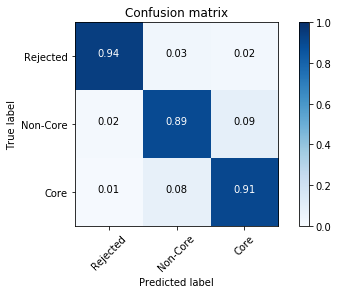

In [272]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()

Confusion matrix, without normalization
[[ 7641   260   191]
 [  275 13717  1341]
 [  158  1082 12537]]


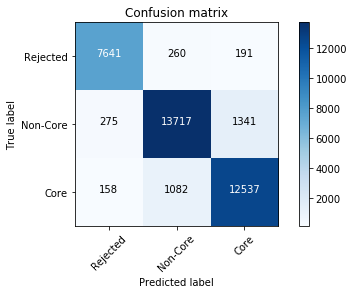

In [273]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=False)
plt.show()

### Look at the mismatches

In [274]:
predictions = pd.DataFrame(data={'text': raw_text, 'ref_fractions': ref_fractions, 'label': pd_labels, 'pred': pd_predicted})

In [275]:
predictions[(predictions.label == 0) &  (predictions.pred == 2)]

,text,ref_fractions,label,pred
80,A Framework for Accelerating Bottlenecks in GP...,"(0.0, 0.0, 0.0, 0.0)",0,2
503,Nonlocal Symmetries and Interaction Solutions ...,"(0.045454547, 0.125, 0.045454547, 0.25)",0,2
703,Micropolarity-Ramification of Laminar/Turbulen...,"(0.0, 0.0, 0.0, 0.0)",0,2
861,Rotating effects on the Landau quantization fo...,"(0.125, 0.2996454, 0.13636364, 0.2429078)",0,2
869,van der Waals-corrected Density Functional The...,"(0.0, 0.0, 0.0, 0.0)",0,2
1031,Fourier Transform of Electric Signal using Kun...,"(0.0, 0.0, 0.0, 0.0)",0,2
1747,Calibration of mixed-polarization interferomet...,"(0.0, 0.0, 0.05882353, 0.13333334)",0,2
1966,On a certain type of nonlinear hyperbolic equa...,"(0.0, 0.0, 0.0, 0.0)",0,2
1983,Adiabatic black hole growth in S\'ersic models...,"(0.15789473, 0.013358778, 0.31578946, 0.4510178)",0,2
2022,Transition radiation on a dynamical periodical...,"(0.09375, 0.32258064, 0.25, 0.25345623)",0,2


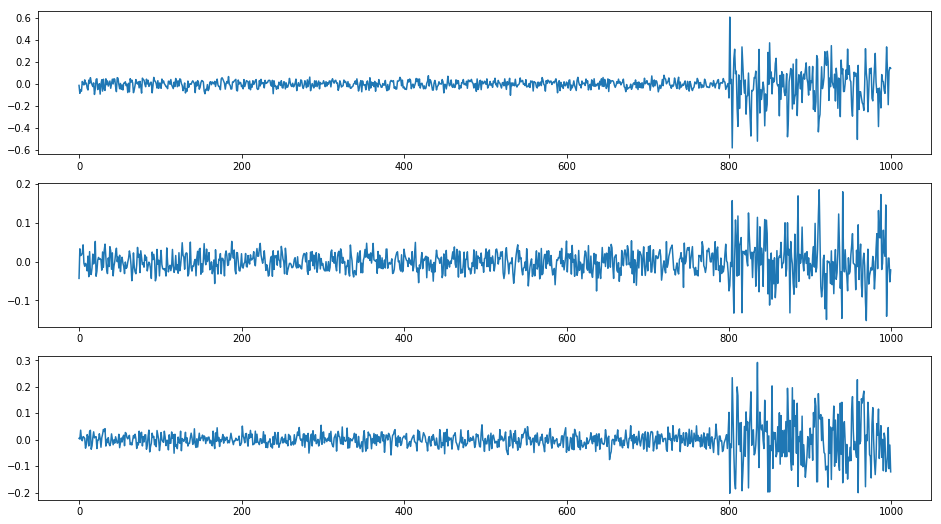

In [276]:
plt.figure(figsize=(16, 9))
plt.subplot(311)
plt.plot(model.fc.weight.cpu().detach().numpy().T[:,0])
plt.subplot(312)
plt.plot(model.fc.weight.cpu().detach().numpy().T[:,1])
plt.subplot(313)
plt.plot(model.fc.weight.cpu().detach().numpy().T[:,2])

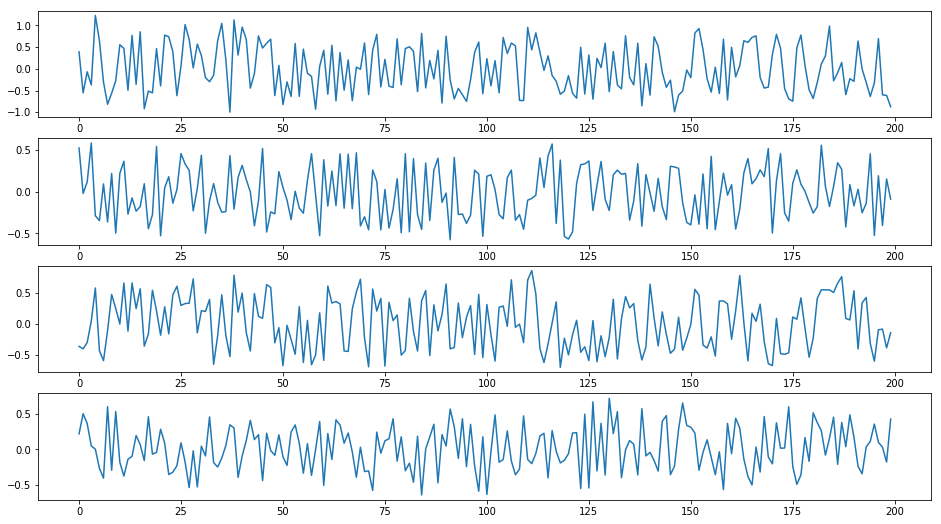

In [277]:
plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.plot(model.fc_reference_fraction.weight.cpu().detach().numpy()[:,0])
plt.plot(np.mean(model.fc_reference_fraction.weight.cpu().detach().numpy()[:,0]))
plt.subplot(412)
plt.plot(model.fc_reference_fraction.weight.cpu().detach().numpy()[:,1])
plt.subplot(413)
plt.plot(model.fc_reference_fraction.weight.cpu().detach().numpy()[:,2])
plt.subplot(414)
plt.plot(model.fc_reference_fraction.weight.cpu().detach().numpy()[:,3])

In [278]:
model

CNN_Classifier_MultiHead(
  (embedding): Embedding(282887, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (fc_reference_fraction): Linear(in_features=4, out_features=200, bias=True)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=1000, out_features=3, bias=True)
)

In [279]:
(
    (model.fc.weight.cpu().detach().numpy().T[:,0].mean(), 
     model.fc.weight.cpu().detach().numpy().T[:800,0].mean(),
     model.fc.weight.cpu().detach().numpy().T[800:,0].mean()
    ),
    (model.fc.weight.cpu().detach().numpy().T[:,1].mean(), 
     model.fc.weight.cpu().detach().numpy().T[:800,1].mean(),
     model.fc.weight.cpu().detach().numpy().T[800:,1].mean()
    ),
    (model.fc.weight.cpu().detach().numpy().T[:,2].mean(), 
     model.fc.weight.cpu().detach().numpy().T[:800,2].mean(),
     model.fc.weight.cpu().detach().numpy().T[800:,2].mean()
    )
)

((-0.0035167544, -0.0020768996, -0.009276172),
 (-0.00033045065, -0.0008265772, 0.0016540565),
 (-0.00065118336, -0.00079949095, -5.795285e-05))

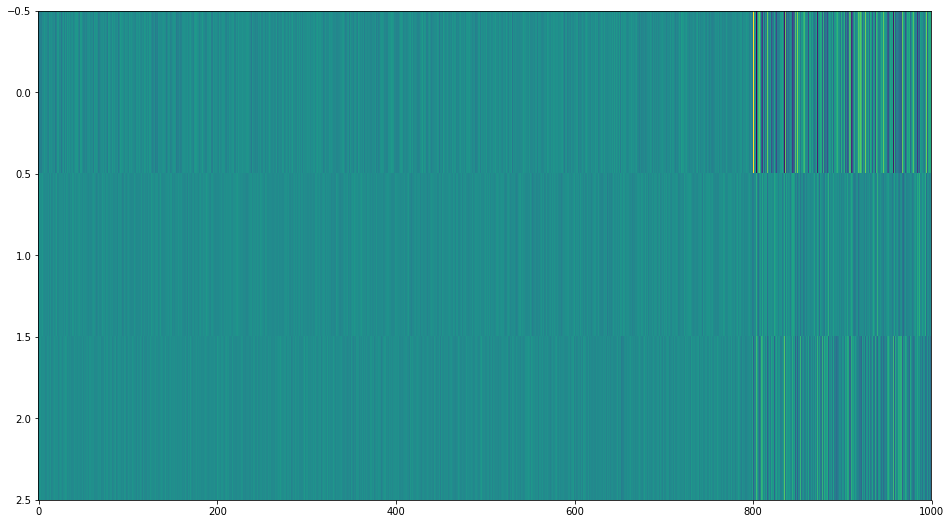

In [280]:
plt.figure(figsize=(16, 9))
plt.imshow(model.fc.weight.cpu().detach().numpy(), aspect='auto')

CNN_Classifier_MultiHead(
  (embedding): Embedding(282887, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (fc_reference_fraction): Linear(in_features=4, out_features=200, bias=True)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=1000, out_features=3, bias=True)
)